### Exercise 2
# Attention for Timeseries Prediction

This time we will learn how to implement attention and how it can improve prediction of timeseries data.

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

In [4]:
timeseries = []

DATAPATH = Path(f"{os.getenv('HOME')}/Datasets/PANJAPAN/benchmarking")
for path in os.listdir(DATAPATH):
    if path.endswith(".csv") and (df := pd.read_csv(DATAPATH / path).to_numpy()).shape == (840, 2):
        timeseries.append(df)

timeseries = np.array(timeseries)
print("Length", len(timeseries))

Length 39


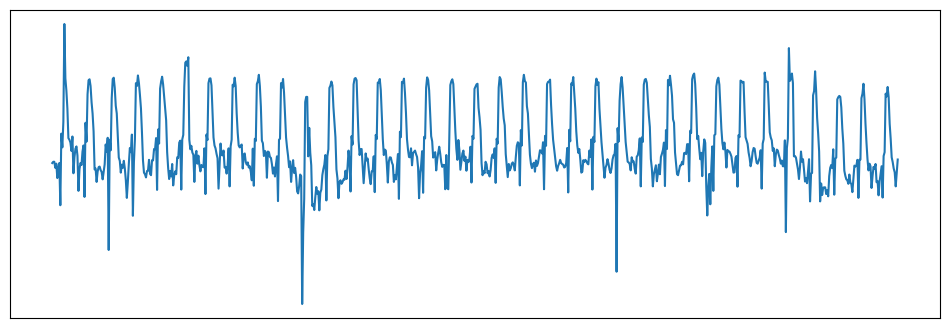

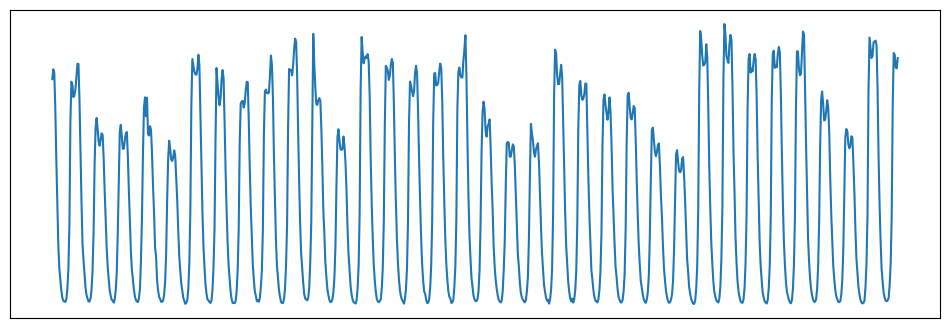

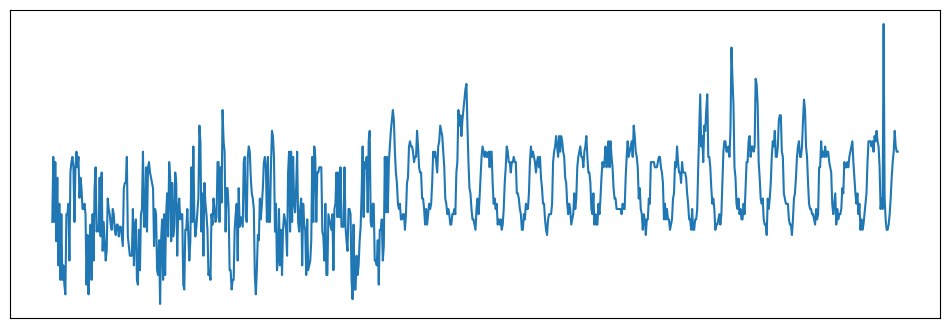

In [5]:
import matplotlib.pyplot as plt

def plot(value, timestamp):
    f = plt.figure(figsize=(12, 4))
    plt.plot(timestamp, value)
    plt.xticks([])
    plt.yticks([])
    return f

_ = plot(timeseries[15, :, 0], timeseries[15, :, 1])
_ = plot(timeseries[35, :, 0], timeseries[35, :, 1])
_ = plot(timeseries[30, :, 0], timeseries[30, :, 1])

In [6]:
from numpy.lib.stride_tricks import sliding_window_view

BACKCAST_LENGTH = 25
FORECAST_LENGTH = 5

def create_windows(series: np.ndarray, axis = 0):
    # Normalize
    mean = np.mean(series, axis=axis)
    std = np.std(series, axis=axis)
    try:
        series = (series - mean) / std
    except:
        ...

    windows = sliding_window_view(series, window_shape=BACKCAST_LENGTH + FORECAST_LENGTH, axis=axis).swapaxes(1, 2)
    windows = torch.tensor(windows).to(dtype=torch.float32)
    
    return windows

In [7]:
from torch.utils.data import DataLoader, random_split

# Set a seed to make experiments repeatable
torch.manual_seed(1337)

# Create three splits at 80%, 90% and 100% of the dataset
train_dataset, valid_dataset, tests_dataset = random_split(timeseries, lengths=(0.75, 0.05, 0.2))

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def plot_updating(*series, figsize = (16, 4), marker='.', logplot = True):
    clear_output(wait=True)
    
    f = plt.figure(figsize=figsize)
    
    for points in series:
        plt.scatter(list(range(len(points))), points, 
            marker=marker, 
            alpha=max(0.1, min(10/len(points), 1.0)))
    
    if logplot:
        plt.semilogy()
    
    plt.show()
    display(plt.gcf())
    return f

### Build Attention Model to predict timeseries

In [9]:
from torch import nn
from math import log, sqrt

class Attention(nn.Module):
    """ Implements Scaled Dot-Product Attention
        as described by "Attention Is All You Need (2017)"
    """
    def __init__(self, embed_size: int, bias = False) -> None:
        super().__init__()
        
        self.Q = nn.Linear(embed_size, embed_size, bias=bias)
        self.K = nn.Linear(embed_size, embed_size, bias=bias)
        self.V = nn.Linear(embed_size, embed_size, bias=bias)
        
        self.out = nn.Linear(embed_size, embed_size)
        
    def forward(self, query, key, value):
        # query: (L_TARGET, EMBED)
        # key: (L_SOURCE, EMBED)
        # value: (L_SOURCE, EMBED)
        query = self.Q(query)
        key   = self.K(key)
        value = self.V(value)
        
        # qk_T : (L_TARGET, L_SOURCE)
        weights = torch.matmul(query, key.permute(0, 2, 1)) / sqrt(key.shape[1])
        weights = torch.softmax(weights, dim=len(weights.shape) - 1)
        
        # (qk_T)*v : (L_TARGET, EMBED)
        attn = torch.matmul(weights, value)
        attn = self.out(attn)
        
        return attn, weights

class PositionalEncoder(nn.Module):
    def __init__(self, emb_size: int, maxlen: int = 5000):
        super().__init__()
        self.emb_size = emb_size
        
        # create constant 'pe' matrix with values dependant on pos and i
        pe = torch.zeros(maxlen, emb_size)
        
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-log(10000.0) / emb_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(dim=0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * sqrt(self.emb_size)
        x = x + torch.autograd.Variable(self.pe[:x.size(0),:], requires_grad=False)
        return x

<Figure size 640x480 with 0 Axes>

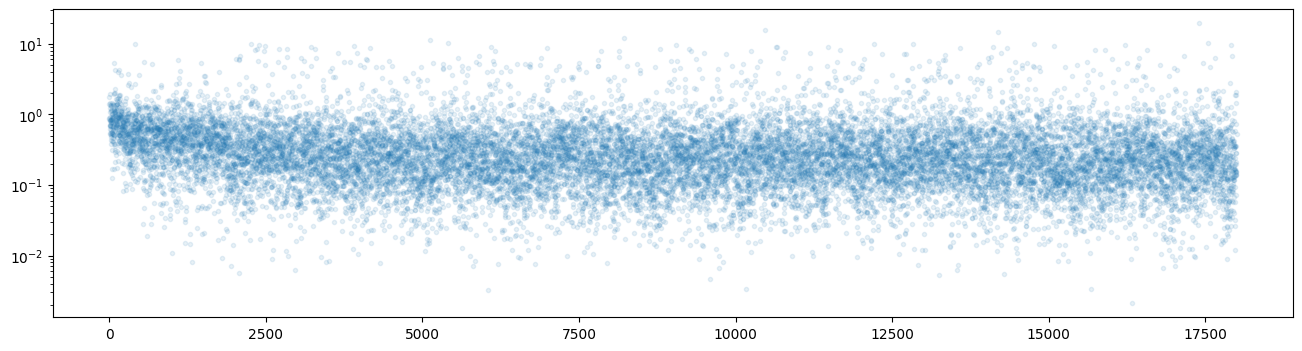

<Figure size 640x480 with 0 Axes>

Epoch 3/3: 100%|██████████| 6083/6083 [00:36<00:00, 165.07it/s]


<Figure size 640x480 with 0 Axes>

In [10]:
from torch import nn
from torch.optim import SGD, Adam
from statistics import mean

DEVICE = torch.device("mps")

class TimeseriesTransformer(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, embed_size = 4) -> None:
        super().__init__()
        
        self.in_proj = nn.Linear(1, embed_size)
        
        self.pe = PositionalEncoder(embed_size)
        self.attn = Attention(embed_size)
        
        self.proj = nn.Linear(embed_size, 1)
        self.out = nn.Linear(backcast_size, forecast_size)
        
    def forward(self, seq):
        seq = self.in_proj(seq)
        
        seq = self.pe(seq)
        seq, w = self.attn(seq, seq, seq)
        
        seq = self.proj(seq).permute(0, 2, 1)
        seq = self.out(seq).permute(0, 2, 1)
        
        return seq, w
    
tsx_model = TimeseriesTransformer(BACKCAST_LENGTH, FORECAST_LENGTH).to(DEVICE)
optimizer = Adam(params=tsx_model.parameters(), lr=1e-3)

losslog = []
for epoch in range(EPOCHS := 3):
    dataset = []
    for series in train_dataset:
        dataset.extend(create_windows(series))

    train_dataloader = DataLoader(dataset, shuffle=True, batch_size=4)
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        optimizer.zero_grad()

        backcast = batch[:, :BACKCAST_LENGTH, 0].to(dtype=torch.float32, device=DEVICE).unsqueeze(2)
        target  = batch[:, BACKCAST_LENGTH:, 0].to(dtype=torch.float32, device=DEVICE)
        
        forecast, _ = tsx_model(backcast)
        loss = nn.functional.mse_loss(forecast.squeeze(2), target)
        
        loss.backward()    
        optimizer.step()
        
        losslog.append(loss.detach().cpu().item())
        
        if len(losslog) % 250 == 0:
            plot_updating(losslog)

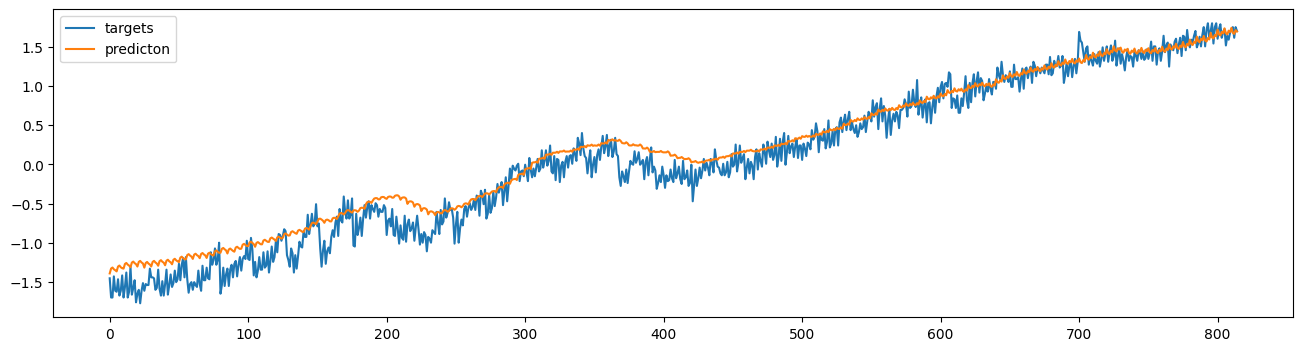

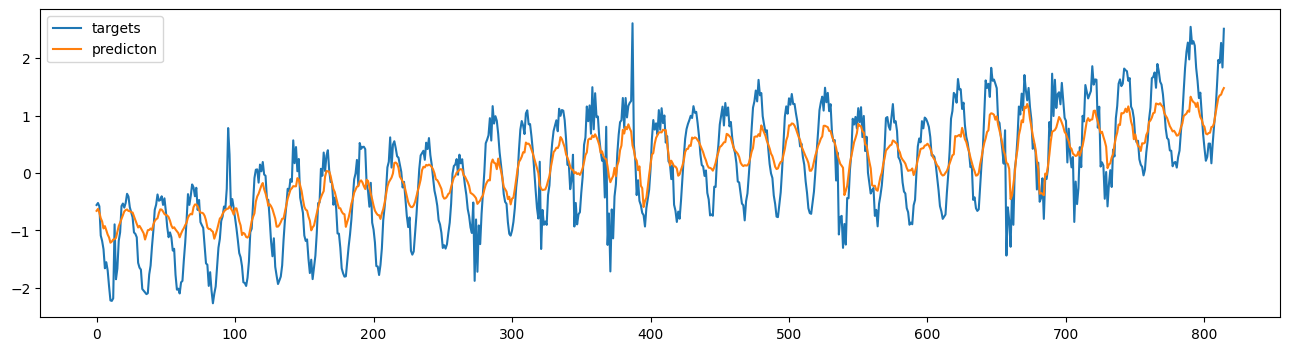

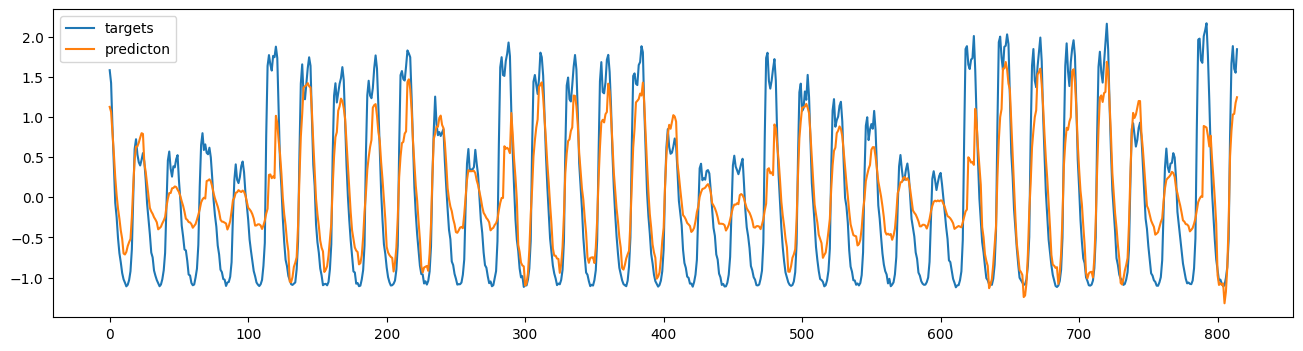

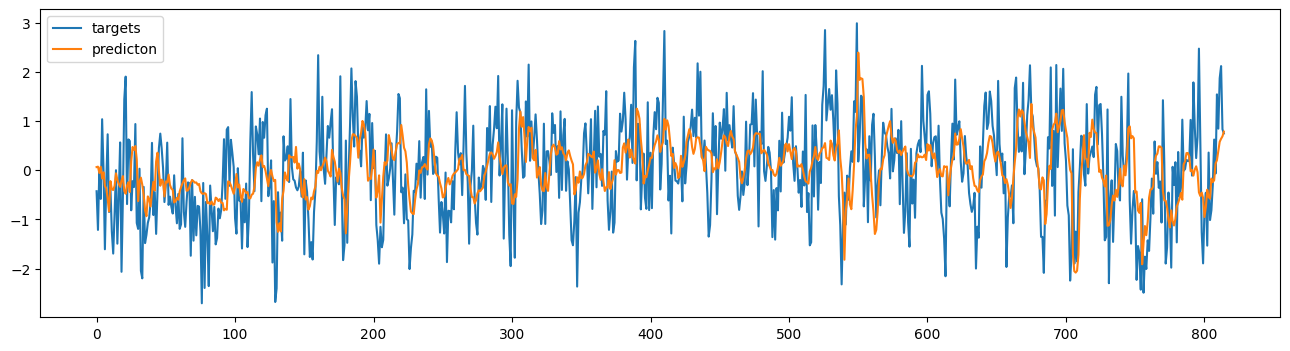

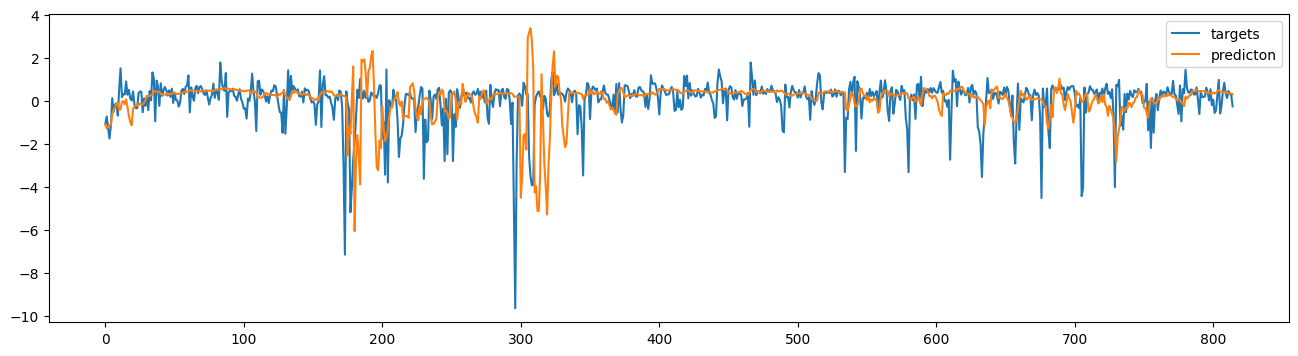

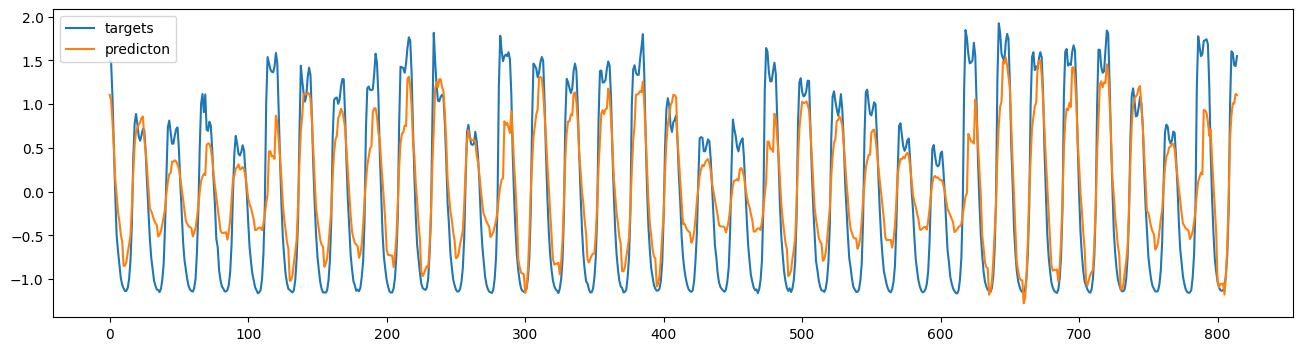

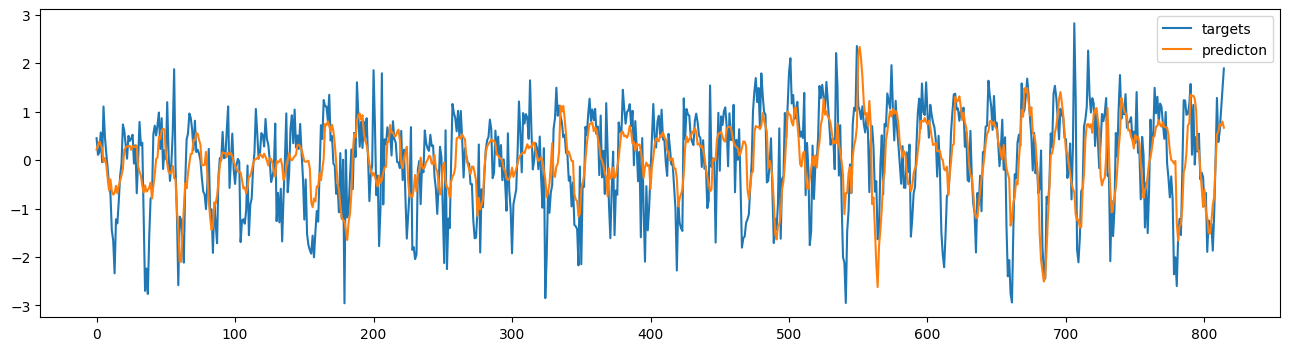

In [274]:
@torch.no_grad()
def predict(series):
    windows = create_windows(series, axis=0).to(dtype=torch.float32, device=DEVICE)
    
    predicted = []
    targets = []

    wix = 0
    while wix < len(windows):
        window = windows[wix]
        
        backcast = window[:BACKCAST_LENGTH, 0].unsqueeze(0).unsqueeze(2)
        
        forecast, _ = tsx_model(backcast)
        predicted.extend(forecast.detach().cpu().numpy().flatten())
        
        target  = window[BACKCAST_LENGTH:, 0]
        targets.extend(target.detach().cpu().numpy().flatten())
        wix += len(target)
        
    f = plt.figure(figsize=(16, 4))
    plt.plot(targets, label="targets")
    plt.plot(predicted, label="predicton")
    plt.legend()
    plt.show()
    
for series in tests_dataset:
    predict(series)